# MST Vincolato
Dato un grafo non orientato e non completo, e dato un nodo r, si determini l’albero di copertura di radice r che minimizza il numero di figli di ogni nodo -1 (dato un albero di copertura, orientato a partire dalla radice, ogni nodo i non foglia ha ki ≥ 1 figli. Si minimizza la somma su tutti i nodi i non foglia di ki-1)

In [1]:
import os
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# PARAMETRI GENERALI
OUT_DIR = "out" # dove salvare i disegni dei grafi (x debug)

ROOT_NODE = 7
MAX_NODES = 126
GRAPH_GENERATOR = "NX_DENSE" # [NX_ATLAS | NX_COMPLETE | NX_DENSE | DENSE | SPARSE ]
RANDOM_SEED = 191295

### Inizializzazione

In [3]:
# CREAZIONE GRAFO e strutture

# TODO importa grafo da file


# Grafo di test
if not "GRAPH_GENERATOR" in globals():
    GRAPH_GENERATOR = "CUSTOM"
else :
    match GRAPH_GENERATOR:
        case "NX_ATLAS": 
            # generatore "atlas" di networkx
            # non sono grafi molto densi, e sono piccoli
            # 666
            # 420
            # 969
            # 1196
            atlas_num = 969
            print("[INFO] Uso generatore nx.atlas (seed={})".format(atlas_num))
            G = nx.graph_atlas(atlas_num)

        case "NX_COMPLETE":
            print("[INFO] Uso generatore grafo completo (n={})".format(MAX_NODES))
            G = nx.complete_graph(range(1,MAX_NODES+1))

        case "NX_DENSE":
            n = MAX_NODES
            m = 2*int(n*(n-2)/3)
            print("[INFO] Uso generatore grafo denso (n={}, m={})".format(n,m))
            if "RANDOM_SEED" in globals():
                seed = RANDOM_SEED
            else:
                print("[WARN] Random seed non impostato. Verrà scelto a caso")
                seed = None
                
            G = nx.dense_gnm_random_graph(n, m, seed=seed)

        
        case "DENSE":
            print("[INFO] Uso generatore mio DENSE")
            G = nx.Graph()
            G.add_nodes_from([
                x for x in range(1, MAX_NODES+1)
            ])

            G.add_edges_from([
                (x,y) for x in range(MAX_NODES, MAX_NODES+1)
                    for y in range(x+1, MAX_NODES+1)
            ])

            # Rendiamo il grafo non completo
            G.remove_edges_from([ (1,4), (3,6), (5,3), (4,5)])
            G.remove_edges_from([ 
                (a,b) for a in range(MAX_NODES, int(MAX_NODES/2))
                      for b in [x for x in range(1,MAX_NODES-1) if (b+a) %3 != 0]
            ])

        case "SPARSE":
            print("[INFO] Uso generatore mio SPARSE")
            G = nx.Graph()
            G.add_nodes_from([
                x for x in range(1, MAX_NODES+1)
            ])

            G.add_edges_from([ 
                (a,b) for a in range(1, int(MAX_NODES/2))
                      for b in [x for x in range(a+1,MAX_NODES+1) if (a+x) % 2 != 0]
            ])

            
        case _:
            # robetta semplice
            atlas_num = 1234
            print("[WARN] Generatore non valido, uso grafo di test (nx.atlas, id=1234)")
            G = nx.graph_atlas(atlas_num)

# Prepara directory in cui salvare i rendering
OUT_DIR = os.path.join(os.getcwd(),OUT_DIR)
if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)

[INFO] Uso generatore grafo denso (n=126, m=10416)


In [4]:
# Alcune funzioni di supporto

def draw_graph(graph, MST=nx.empty_graph(), root_node=None):
    # adapted from:
    # https://stackoverflow.com/questions/60164893/highlighting-certain-nodes-edges-in-networkx-issues-with-using-zip

    nodes_shared_options = {"node_size": 500, "edgecolors": "black", "linewidths": 1.2}
    edges_shared_options = {"connectionstyle": 'arc3', "width": 1.25} 
    
    # Get position using spring layout
    pos = nx.spring_layout(graph, seed=54321)
    #pos = nx.circular_layout(graph)

    # Get MST path
    path_edges = list(MST.edges)

    # Prepare the figure size
    plt.figure(figsize=(max(8,MAX_NODES/6),max(8,MAX_NODES/6)))

    # Draw nodes and edges not included in the MST path
    #nx.draw_networkx_nodes(graph, pos, nodelist=set(graph.nodes)-set(MST.nodes))
    nx.draw_networkx_nodes(graph, pos, nodelist=graph.nodes, node_color="whitesmoke", **nodes_shared_options)
    nx.draw_networkx_edges(graph, pos, edgelist=set(graph.edges)-set(path_edges), edge_color='gray', **edges_shared_options )

    # Draw MST path
    # highlight the root node
    if root_node != None:
        nx.draw_networkx_nodes(graph, pos, nodelist=[root_node], node_color='tab:red', **nodes_shared_options)

    nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color='r', **edges_shared_options)

    # Draw labels
    nx.draw_networkx_labels(graph, pos, font_color='black', font_weight='bold')
    nx.draw_networkx_labels(graph, pos, labels={root_node: root_node}, font_color='whitesmoke', font_weight='bold')



def save_figure(name, format="svg"):
    filename = "{}.{}".format(name,format)
    plt.tight_layout(pad=1)
    plt.savefig(os.path.join(OUT_DIR,filename), bbox_inches='tight', format=format, dpi=800, transparent=True)



In [5]:
# Funzione obiettivo

def cost(MST, root_node=ROOT_NODE, debug=False):

    if debug:
        print("root node: ",root_node)

    support_graph = nx.Graph()

    visited = set()
    next = [root_node]
    
    cost = 0

    while len(next) > 0:
        node = next.pop(0)
        node_edges = MST.edges(node)
        
        if node not in visited:
            k_children = len( [ x for x in node_edges if x not in support_graph.edges ] )

            if debug:
                print("node {} has {} children".format(node, k_children))

            if k_children > 1:
                cost += k_children - 1

            visited.add(node)
            next = next + list(MST.adj[node])
            support_graph.add_edges_from(node_edges)
        
    return cost


root node:  1
node 1 has 2 children
node 2 has 3 children
node 6 has 0 children
node 3 has 0 children
node 5 has 0 children
node 4 has 0 children
cost:  3


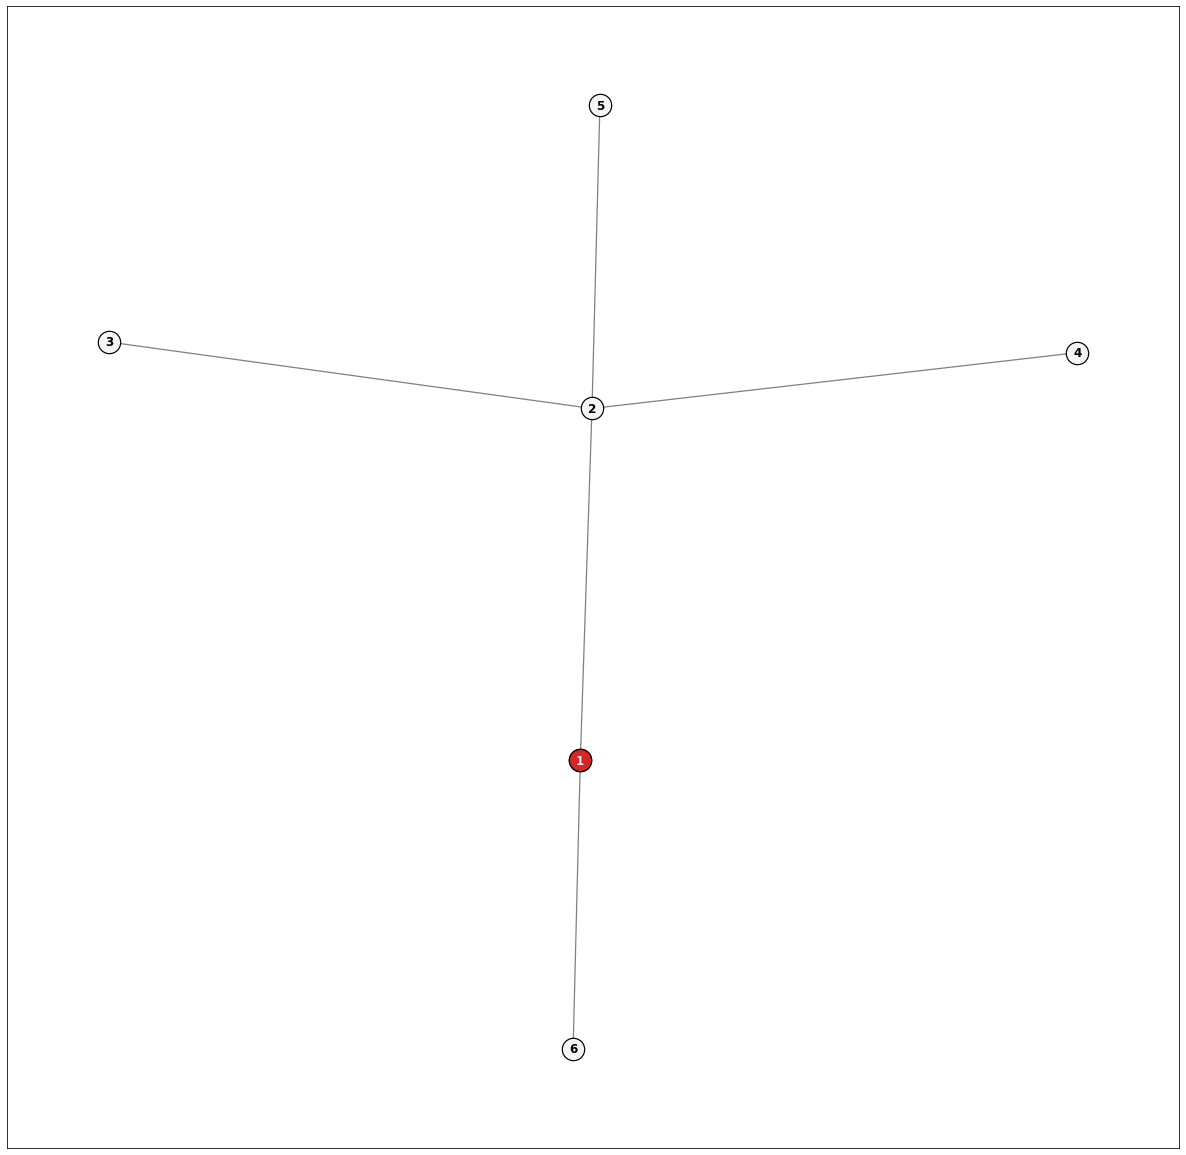

In [6]:
# TEST cost() children nodes
TEST = nx.Graph()
TEST.add_edges_from([(1, 2), (2, 3), (2, 5), (1, 6), (2, 4)])

TEST_ROOT = 1

draw_graph(TEST, root_node=TEST_ROOT)

print("cost: ",cost(TEST, 1,debug=True))

---DETTAGLI---
|V| =  126
|E| =  7875

---TEST AMMISSIBILITA'---
graph is complete:  True


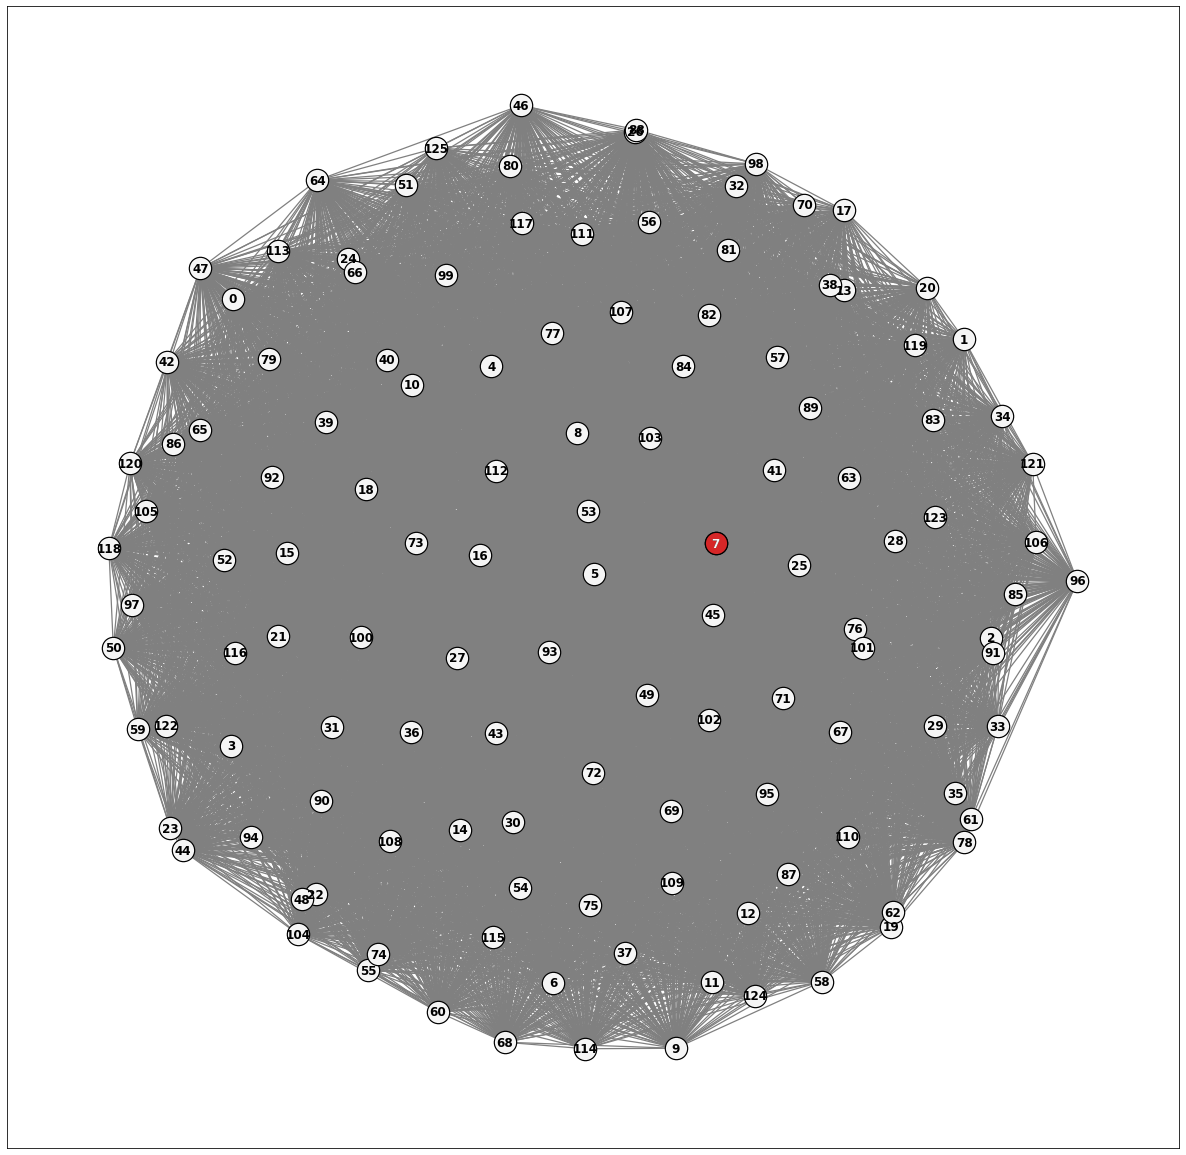

In [7]:
print("---DETTAGLI---")
V = G.number_of_nodes()
E = G.number_of_edges()
print("|V| = ", V)
print("|E| = ", E)



print("")
print("---TEST AMMISSIBILITA'---")

print("graph is complete: ",(E == V*(V-1)/2))

draw_graph(G, root_node=ROOT_NODE)

## Ricerca Locale

In [8]:
# PARAMETRI RICERCA
MAX_ITER = 36000    # Criterio di stop: arresta la ricerca dopo queste iterazioni (es. se il grafo è troppo grosso)
DEBUG_IMPROVEMENT = False
SAVE_STEP_GRAPHS = False

### 1. Creazione soluzione ammissibile

Parto da un MST subottimale ottenuto con la visita in ampiezza a partire dalla radice. Uso la visita in ampiezza perchè
* è relativamente semplice costruire uno spanning tree così
* se la radice è abbastanza connessa ottengo una soluzione che sicuramente può essere migliorata

In [9]:
# Creazione di MST ammissibile a partire dal nodo radice specificato
# tramite visita in ampiezza (così ho un punto di partenza volutamente poco buono)
def build_rooted_mst(graph, root_node):
    visited_nodes = set() # per evitare cicli
    next_visit = []

    MST = nx.Graph()

    #MST.add_node(n1) # non necessario, aggiunti in automatico con gli archi

    #next_visit = list(G.adj[root_node]) # inserisci i vicini del nodo di partenza

    next_visit.insert(0,root_node) # assicurati di partire dal nodo radice!
    #for n in next_visit:
    while len(next_visit) > 0:
        n = next_visit.pop(0)
        # processa un nodo solo se non è già stato visitato
        if n not in visited_nodes:
            visited_nodes.add(n)
            # aggiungi i suoi vicini non visitati alla lista/stack di visita
            unvisited_neighbourhood = [x for x in list(G.adj[n]) if x not in visited_nodes]
            #print("n = ",n)
            #print("unvisited_neighbourhood = ",unvisited_neighbourhood)
            #print("(before loop) next_visit = ",next_visit)
            # inserimento in testa -> depth first?
            next_visit = unvisited_neighbourhood + next_visit
            for neighbour in unvisited_neighbourhood:
                if neighbour not in MST.nodes:
                    #print("MST edge added: ", (n,neighbour))
                    MST.add_edge(n,neighbour)
            #print("(after loop) next_visit = ",next_visit) 
        #else:
            #print("n = ", n, "(ignored)")

    return MST

In [10]:
mst = build_rooted_mst(G, ROOT_NODE)

In [11]:
# PRINT INFO SOL. INIZIALE
print("Costo iniziale:", cost(mst))
print("MST = ", mst.edges)

Costo iniziale: 124
MST =  [(7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 8), (7, 9), (7, 10), (7, 11), (7, 12), (7, 13), (7, 14), (7, 15), (7, 16), (7, 17), (7, 18), (7, 19), (7, 20), (7, 21), (7, 22), (7, 23), (7, 24), (7, 25), (7, 26), (7, 27), (7, 28), (7, 29), (7, 30), (7, 31), (7, 32), (7, 33), (7, 34), (7, 35), (7, 36), (7, 37), (7, 38), (7, 39), (7, 40), (7, 41), (7, 42), (7, 43), (7, 44), (7, 45), (7, 46), (7, 47), (7, 48), (7, 49), (7, 50), (7, 51), (7, 52), (7, 53), (7, 54), (7, 55), (7, 56), (7, 57), (7, 58), (7, 59), (7, 60), (7, 61), (7, 62), (7, 63), (7, 64), (7, 65), (7, 66), (7, 67), (7, 68), (7, 69), (7, 70), (7, 71), (7, 72), (7, 73), (7, 74), (7, 75), (7, 76), (7, 77), (7, 78), (7, 79), (7, 80), (7, 81), (7, 82), (7, 83), (7, 84), (7, 85), (7, 86), (7, 87), (7, 88), (7, 89), (7, 90), (7, 91), (7, 92), (7, 93), (7, 94), (7, 95), (7, 96), (7, 97), (7, 98), (7, 99), (7, 100), (7, 101), (7, 102), (7, 103), (7, 104), (7, 105), (7, 106), (7, 107), (7, 108), 

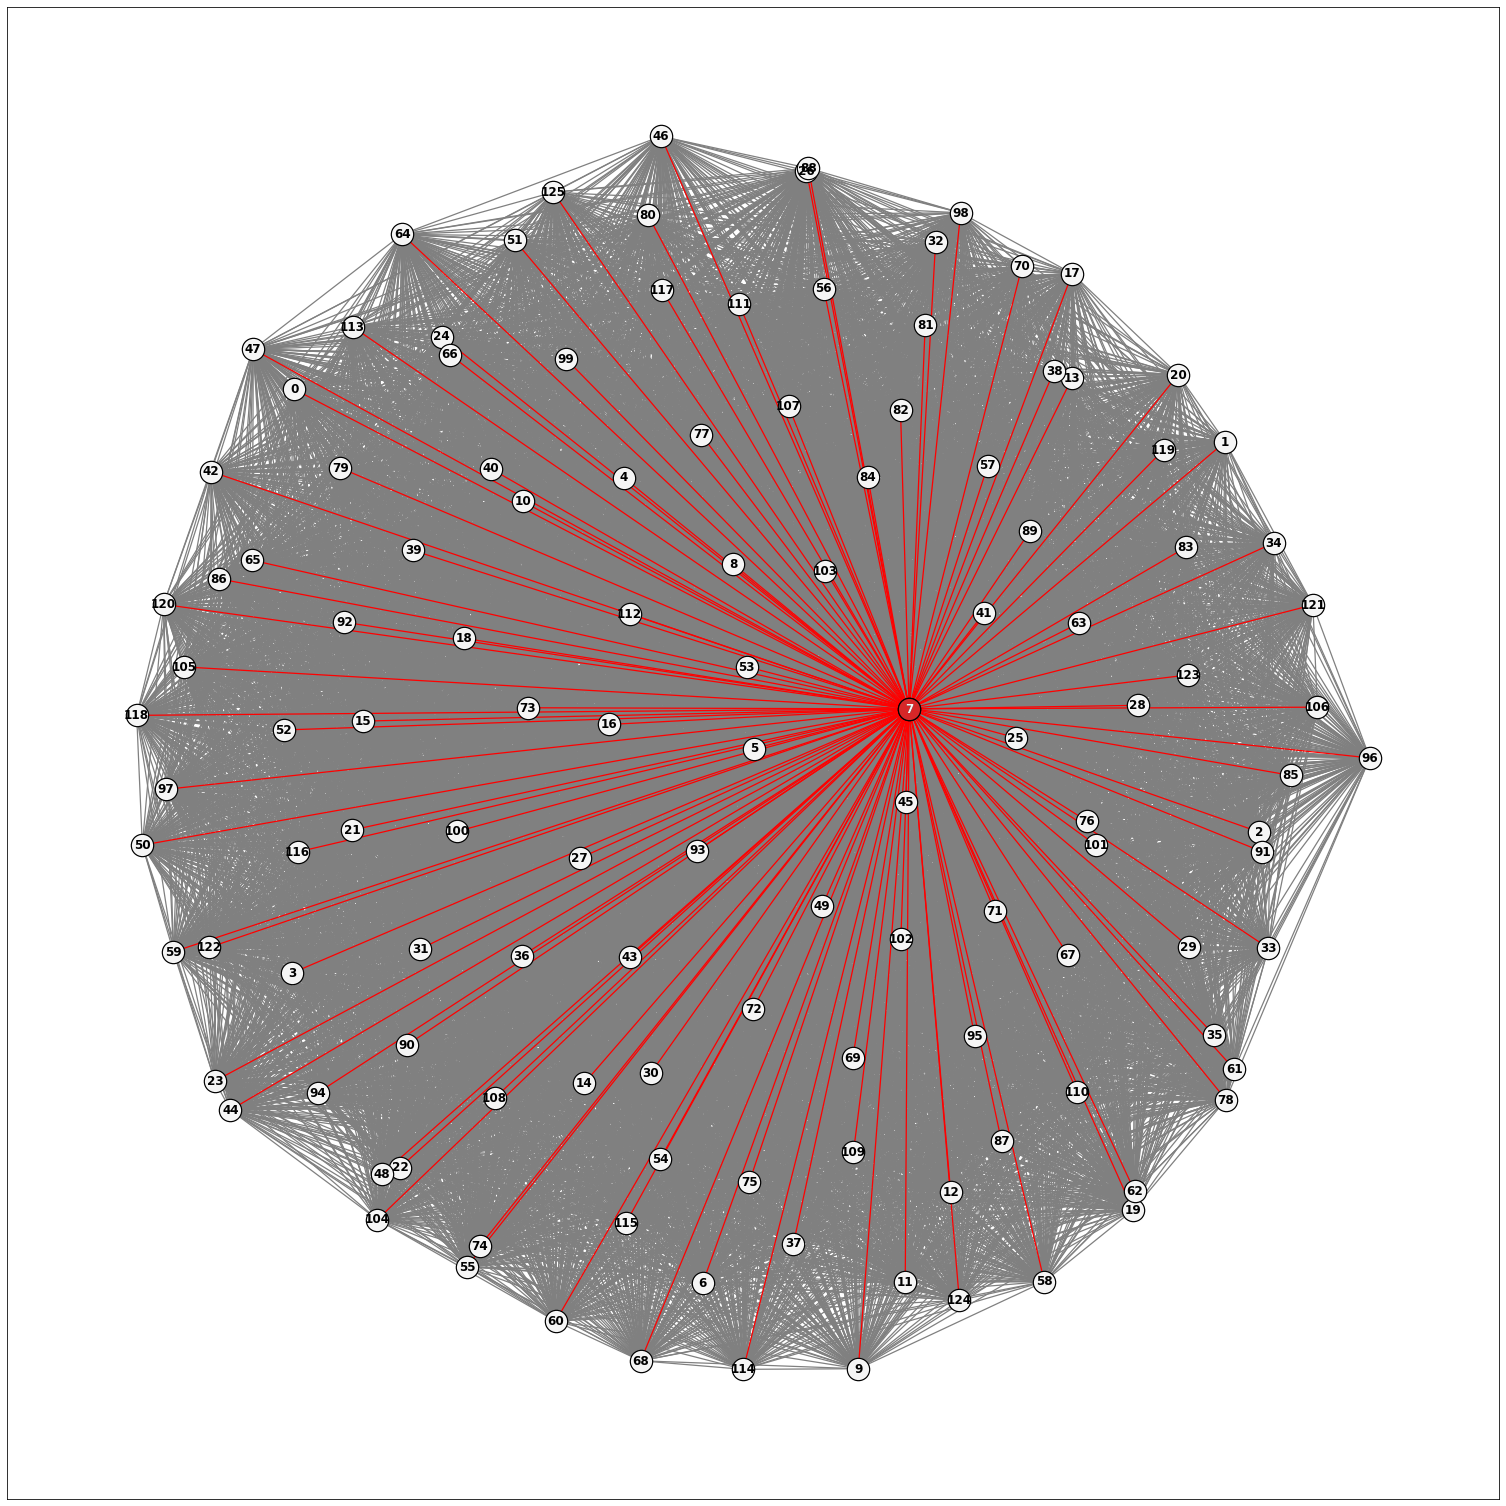

In [12]:
# RENDERING MST INIZIALE SUL GRAFO
draw_graph(G, mst, ROOT_NODE)
save_figure(name="initial")

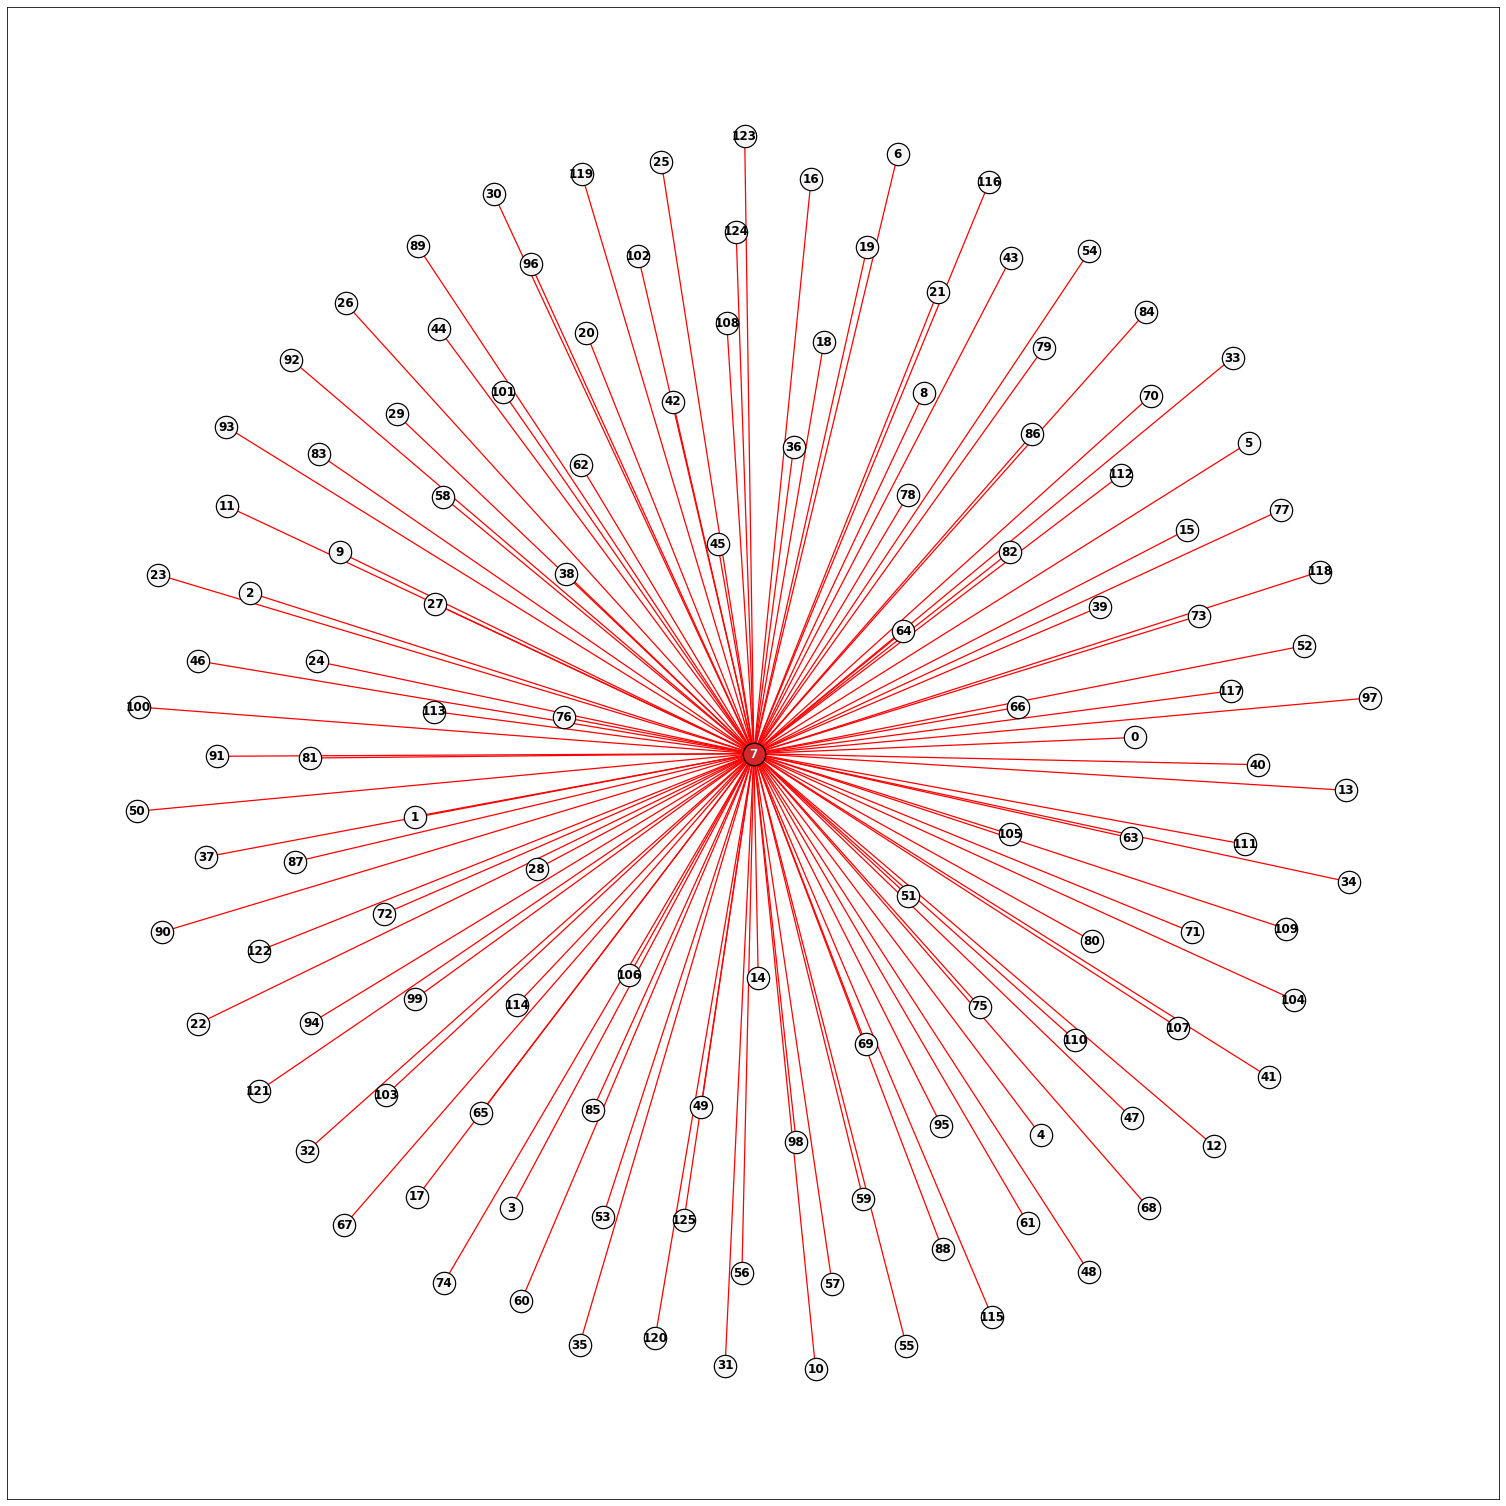

In [13]:
# RENDERING MST INIZIALE
draw_graph(mst, mst, ROOT_NODE)
save_figure(name="mst_initial")

### 2. Improvement

Miglioro per scambio di archi, con una strategia quasi greedy.

> Possibili miglioramenti?

* ~~TODO provare con grafi grossi~~ soluzioni parecchio subottimali (con 16 nodi, c=10 quando ottimo è c=0)
    * **[migliorato]** consentendo swap con archi eliminati (c=6)


In [14]:
# calcolo il grafo complementare all'MST
outer_G = G.copy()
outer_G.remove_edges_from(mst.edges)

# Sostituti candidati = archi che possono sostituire quelli in soluzione
# Uso questa lista per non dover ricalcolare outer_G a ogni iterazione (inefficiente!)
out_candidates = list(outer_G.edges)
k = 0

if DEBUG_IMPROVEMENT:
    print("NON IN MST:", outer_G.edges)
    print("MST:", mst.edges)

    plt.figure(0)
    plt.title("Initial")
    draw_graph(G, mst, root_node=ROOT_NODE)
    if "SAVE_STEPS_GRAPH" in globals() and SAVE_STEPS_GRAPH:
        plt.savefig( os.path.join(OUT_DIR, "debug_Steps",'iter_{}'.format(k)) )


In [15]:
# CICLO DI MIGLIORAMENTO

iter = 0
while len(out_candidates) > 0 and iter < MAX_ITER:
    iter += 1
    cost_before = cost(mst)

    # Se sono così fortunato da aver trovato la soluzione ottima,
    # ferma tutto (non si può mai migliorare più di così)
    if cost_before == 0:
        break

    new_e = out_candidates.pop(0)
    # Assicurati che l'arco estratto non sia stato (re)inserito 
    # nell'MST dopo la sua rimozione da un'altra mossa
    # (questa cosa serve solo perchè non ricreo il grafo complementare a ogni iterazione)
    while new_e in mst.edges:
        if len(out_candidates) == 0:
            break
        new_e = out_candidates.pop(0)

    if DEBUG_IMPROVEMENT:
        print("")
        print(k,") initial cost: ",cost_before)
        print("MST=", list(mst.edges))
        print("add: ",new_e)

    # aggiungo un arco all'MST
    # ciò causerà la nascita di un ciclo nel grafo, perchè MST è sottinsieme massimale di archi senza cicli
    # quindi elimino un arco del ciclo che si è venuto a creare <=> la funzione obiettivo migliora
    mst.add_edges_from([new_e])

    # loop detection
    loop_edges = nx.algorithms.cycles.find_cycle(mst)


    cost_improved = False
    # 1: eliminazione GREEDY dell'arco in più
    # scelgo la mossa che localmente mi da l'abbassamento minore di obj()
    for out_e in [e for e in loop_edges if e != new_e]:
        #print(k,"MST=",mst.edges); 
        k+=1;
        cost_before = cost(mst, ROOT_NODE)
        mst.remove_edges_from([out_e])
        
        if DEBUG_IMPROVEMENT:
            fig = plt.figure(k)
            plt.title("add: {}, remove: {}".format(new_e, out_e))
            draw_graph(G, mst, root_node=ROOT_NODE )
            if "SAVE_STEP_GRAPHS" in globals() and SAVE_STEP_GRAPHS:
                plt.savefig(os.path.join(OUT_DIR,"debug_Steps",'iter_{}'.format(k)))
            print("remove: ", out_e)
            
        cost_after = cost(mst)

        if cost_after > cost_before:
            # annulla e prova a rimuovere un altro arco
            mst.add_edges_from([out_e])
            if DEBUG_IMPROVEMENT:
                print("new cost: ",cost_after, "(revert)")
        else:
            # rendi la modifica permanente e passa oltre.
            # non esploro gli altri archi candidati per lo scambio 
            # perchè con una mossa del genere
            # il costo può essere ridotto solo di 1
            if DEBUG_IMPROVEMENT:
                print("new cost: ",cost_after, "(keep)")
            cost_improved = True

            # Se e solo se l'arco rimosso forniva una soluzione equivalente,
            # lo (ri)metto nell'insieme dei candidati
            # nel caso mi serva per migliorare più avanti
            # (lo metto in fondo alla lista per 
            #  dare priorità alle sostituzioni non ancora tentate)
            if cost_after == cost_before:
                out_candidates.append(out_e)


            break

        # se non ci sono stati miglioramenti, 
        # rimuovi l'arco aggiunto e provane un altro
        if not cost_improved:
            if DEBUG_IMPROVEMENT:
                print("No improvements, removing: ",new_e)
            mst.remove_edges_from([new_e])
            out_candidates.append(new_e)


### 3. Risultati


In [16]:
# PRINT RESULTS
print("Costo finale: ", cost(mst))
print("MST = ",mst.edges)

print("")
print("---STATISTICHE---")
print("Iterazioni eseguite: {}/{}".format(iter,MAX_ITER))
print("Figli nodi non ottimali: ",[{n: x-(ROOT_NODE!=n)*1} for (n,x) in mst.degree() if x > 2])
V = G.number_of_nodes()
E = G.number_of_edges()
print("|V| = ", V)
print("|E| = ", E)



print("")
print("---TEST AMMISSIBILITA'---")

print("graph is complete: ",(E == V*(V-1)/2))

print("mst is tree: ",nx.is_tree(mst))

try:
    cycletest = nx.algorithms.cycles.find_cycle(mst, orientation="ignore")
except:
    cycletest = None
finally:
    print("mst loops: ", cycletest)


Costo finale:  32
MST =  [(7, 124), (0, 3), (0, 6), (1, 6), (1, 12), (2, 124), (2, 122), (4, 8), (5, 119), (6, 11), (8, 119), (9, 120), (10, 121), (10, 13), (11, 87), (13, 84), (14, 19), (14, 65), (15, 118), (15, 19), (16, 112), (16, 28), (17, 21), (17, 20), (18, 25), (18, 79), (18, 39), (19, 24), (20, 27), (20, 117), (21, 39), (22, 25), (23, 28), (23, 26), (26, 32), (26, 35), (29, 34), (30, 116), (30, 33), (30, 47), (31, 59), (31, 107), (31, 77), (33, 73), (33, 63), (34, 37), (35, 60), (36, 42), (36, 72), (37, 40), (38, 53), (40, 63), (40, 72), (41, 49), (41, 99), (41, 44), (43, 67), (43, 51), (45, 82), (46, 54), (46, 77), (48, 60), (48, 68), (48, 80), (49, 52), (50, 114), (50, 80), (53, 60), (54, 57), (55, 62), (55, 64), (56, 80), (56, 63), (56, 67), (58, 69), (58, 82), (58, 73), (61, 81), (64, 67), (65, 69), (66, 71), (68, 74), (70, 74), (71, 80), (75, 83), (75, 99), (76, 83), (78, 114), (81, 105), (83, 89), (84, 89), (85, 103), (85, 105), (85, 94), (86, 92), (87, 90), (88, 96), (88

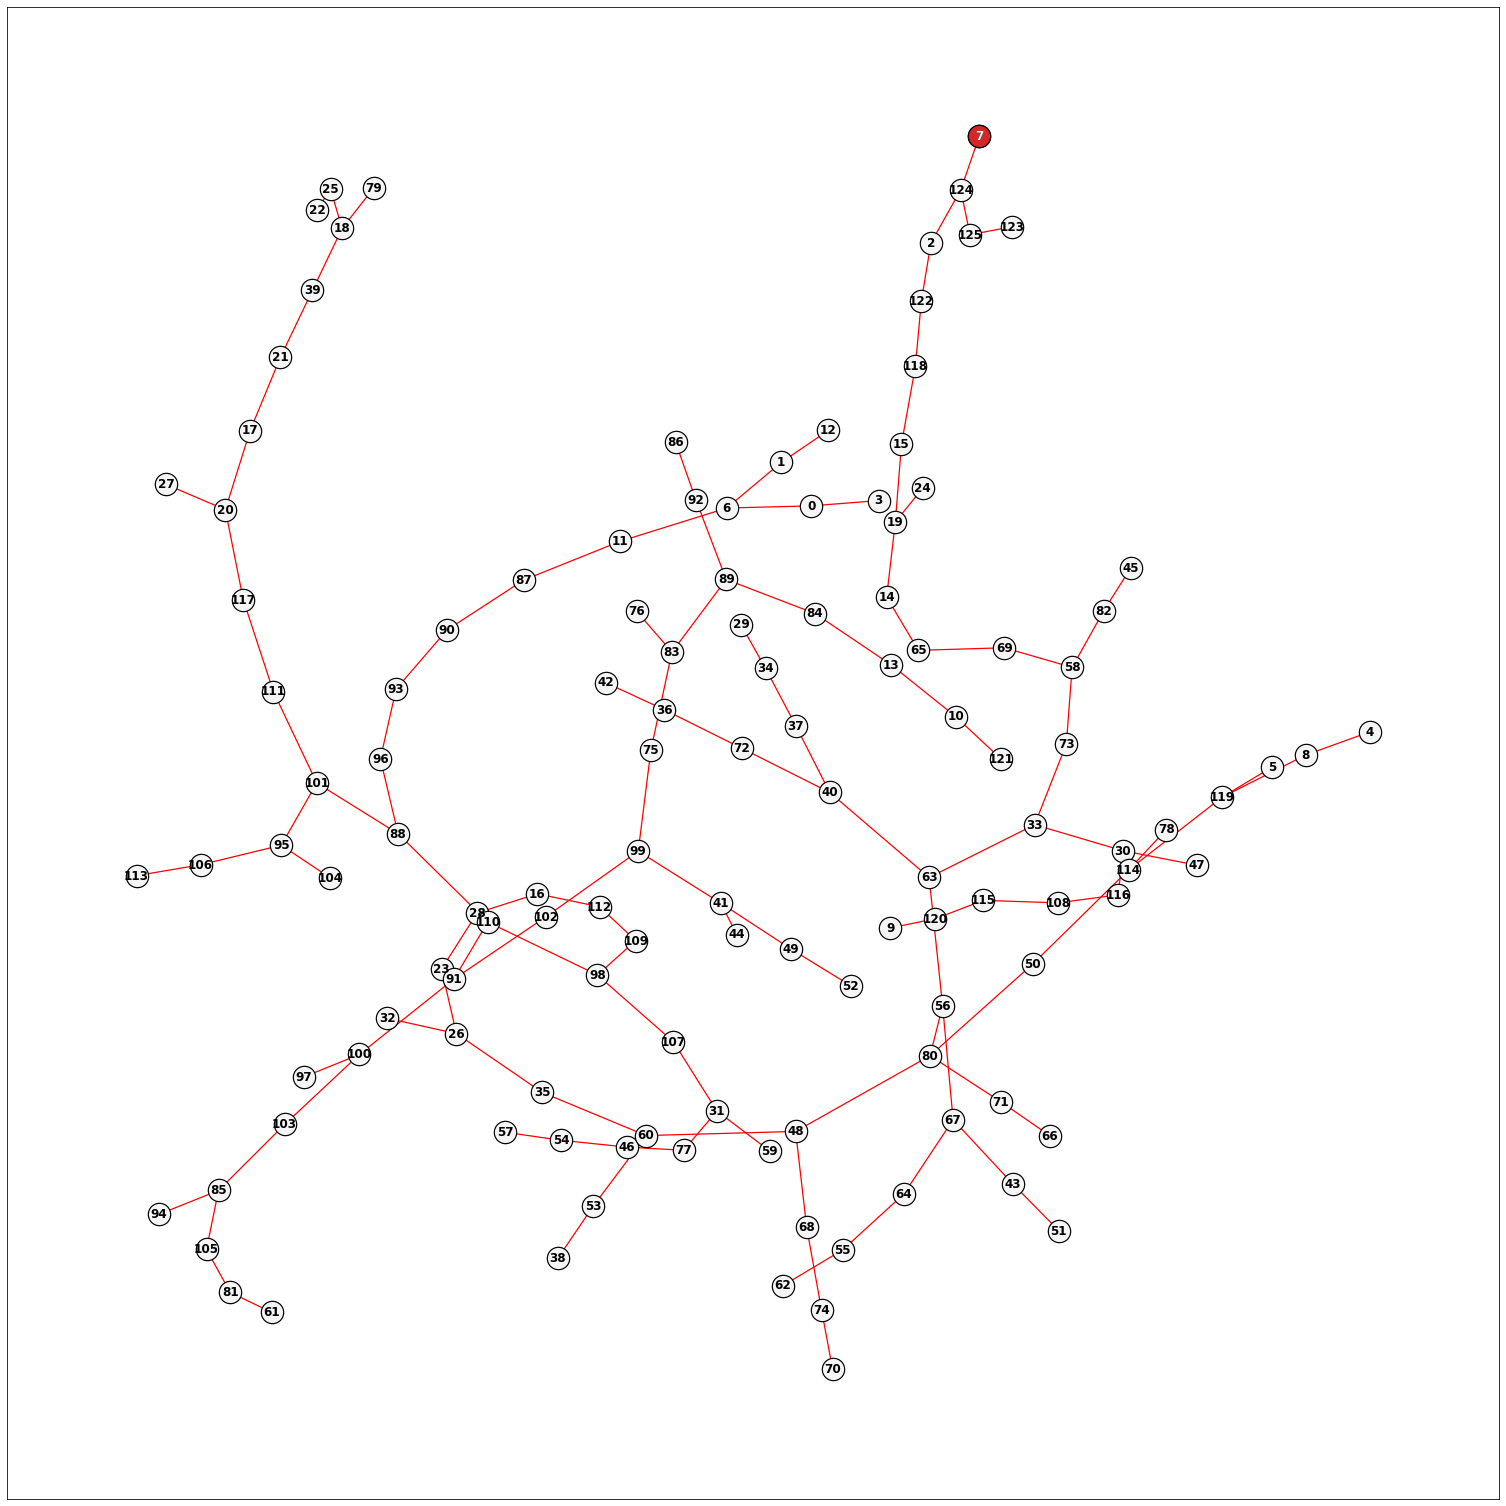

In [17]:
# RENDERING MST
draw_graph(mst, mst, ROOT_NODE)
save_figure(name="mst_final")

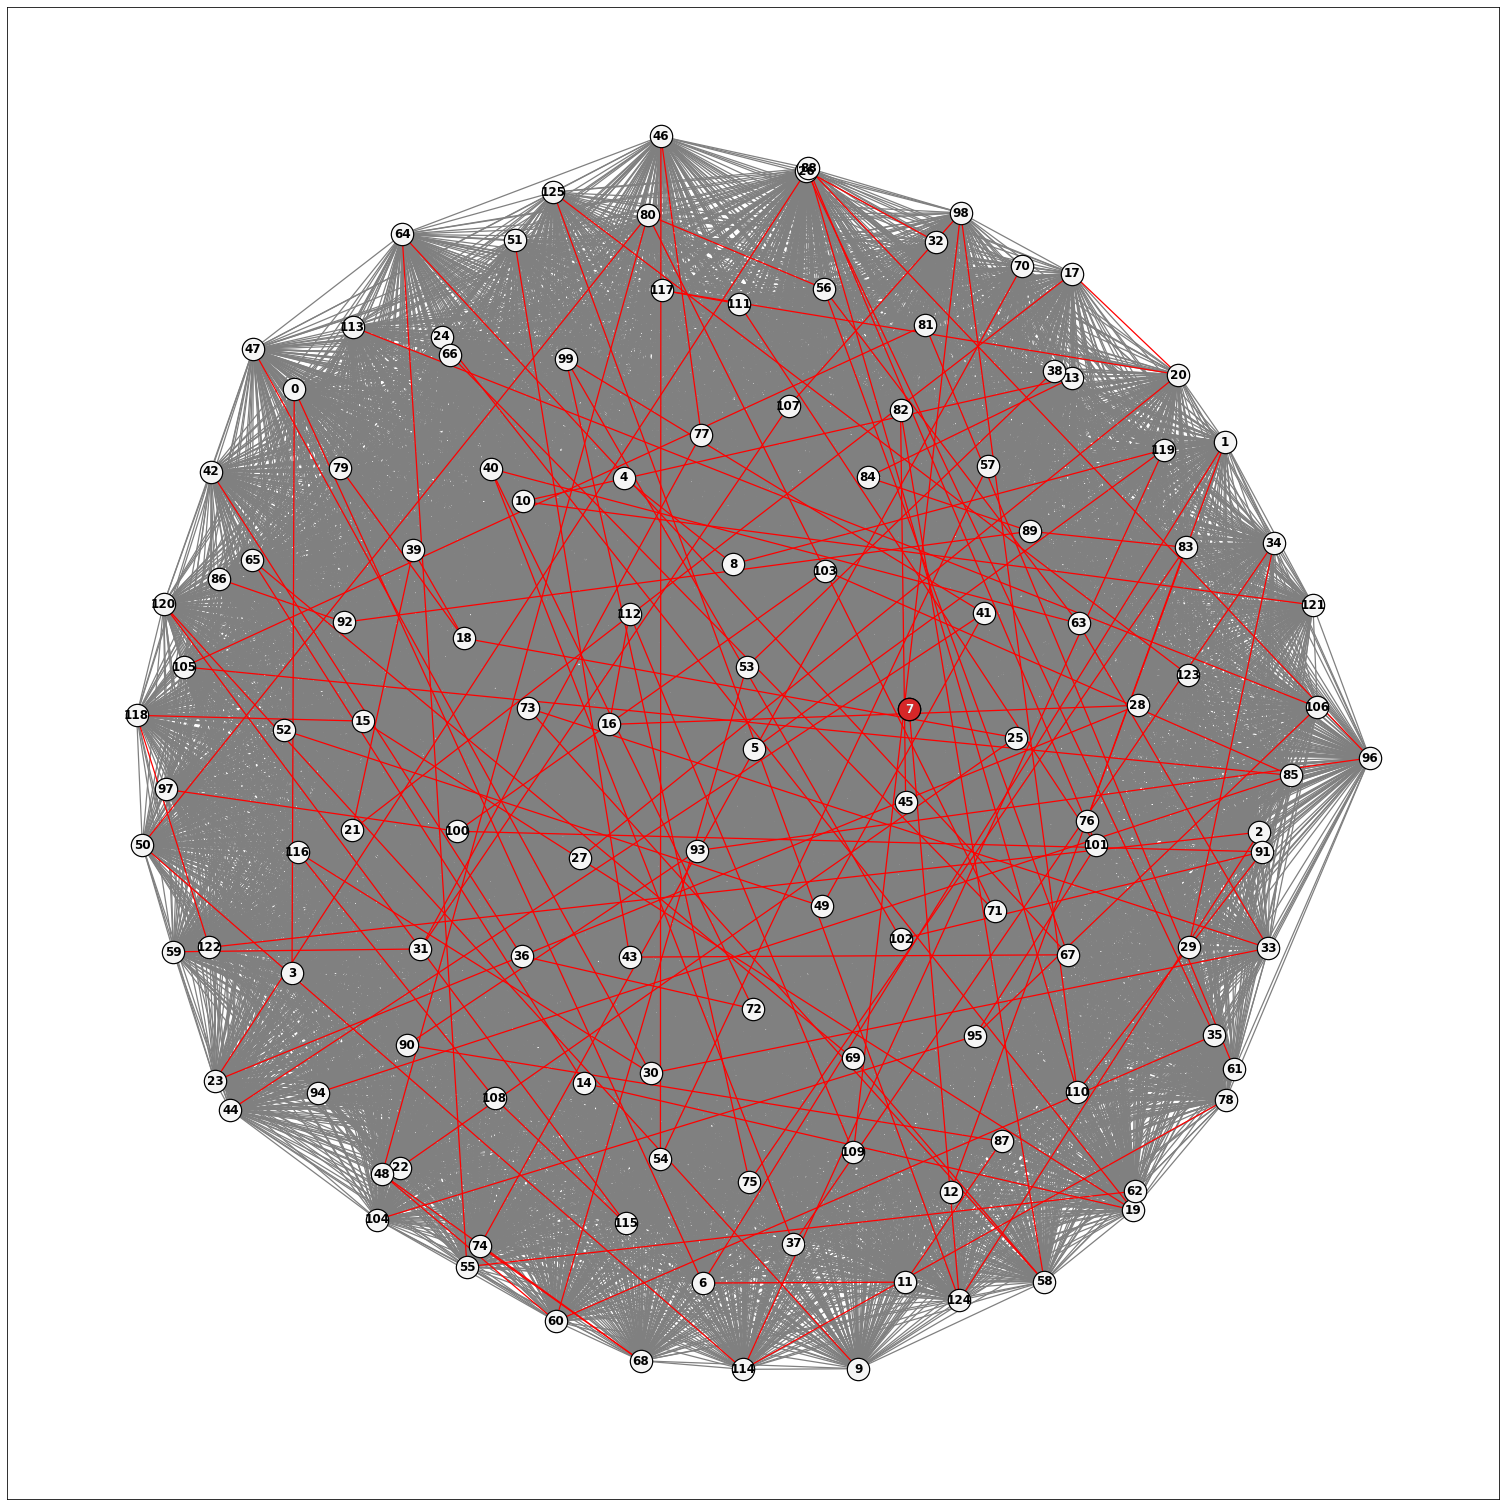

In [18]:
# RENDERING MST SOPRA AL GRAFO
draw_graph(G, mst, ROOT_NODE)
save_figure(name="final")